In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import statsmodels.api as sm
from itertools import combinations
from statsmodels.tsa.stattools import coint
from pykalman import KalmanFilter

In [2]:
nifty_50_tickers = [
    'RELIANCE.NS', 'TCS.NS', 'INFY.NS', 'HDFCBANK.NS', 'ICICIBANK.NS',
    'KOTAKBANK.NS', 'HINDUNILVR.NS', 'SBIN.NS', 'ITC.NS', 'LT.NS',
    'BHARTIARTL.NS', 'ASIANPAINT.NS', 'AXISBANK.NS', 'BAJFINANCE.NS',
    'MARUTI.NS', 'WIPRO.NS', 'ULTRACEMCO.NS', 'NTPC.NS', 'POWERGRID.NS',
    'NESTLEIND.NS', 'SUNPHARMA.NS', 'TECHM.NS', 'TITAN.NS', 'JSWSTEEL.NS'
]

def get_price_data(tickers, start='2022-01-01', end='2024-01-01'):
    print("Downloading price data...")
    data = yf.download(tickers, start=start, end=end)['Close']
    data = data.dropna(axis=1)
    print(f"Retrieved {data.shape[1]} stocks.")
    return data

prices = get_price_data(nifty_50_tickers)

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  24 of 24 completed

Retrieved 24 stocks.


In [4]:
def find_cointegrated_pairs(price_data):
    pairs, scores, pvalues = [], [], []
    tickers = price_data.columns
    for (i, j) in combinations(tickers, 2):
        score, pvalue, _ = coint(price_data[i], price_data[j])
        pairs.append((i, j))
        scores.append(score)
        pvalues.append(pvalue)

    result_df = pd.DataFrame({'Pair': pairs, 'Cointegration Score': scores, 'P-value': pvalues})
    return result_df.sort_values('P-value')

cointegration_df = find_cointegrated_pairs(prices)
display(cointegration_df.head())
top_pair = tuple(cointegration_df.iloc[0]['Pair'])
print("Top Cointegrated Pair:", top_pair)

,Pair,Cointegration Score,P-value
80,"(BHARTIARTL.NS, SUNPHARMA.NS)",-4.278074,0.002769
83,"(BHARTIARTL.NS, TITAN.NS)",-3.990221,0.007415
210,"(MARUTI.NS, NESTLEIND.NS)",-3.866142,0.011039
75,"(BHARTIARTL.NS, NESTLEIND.NS)",-3.861931,0.011186
30,"(AXISBANK.NS, JSWSTEEL.NS)",-3.747578,0.015898


Top Cointegrated Pair: ('BHARTIARTL.NS', 'SUNPHARMA.NS')


In [5]:
def kalman_filter_hedge_ratio(y, x):
    delta = 1e-5
    trans_cov = delta / (1 - delta) * np.eye(2)
    obs_mat = np.vstack([x, np.ones(len(x))]).T[:, np.newaxis]

    kf = KalmanFilter(
        n_dim_obs=1, n_dim_state=2,
        initial_state_mean=[0, 0], initial_state_covariance=np.ones((2, 2)),
        transition_matrices=np.eye(2), observation_matrices=obs_mat,
        observation_covariance=1.0, transition_covariance=trans_cov
    )

    state_means, _ = kf.filter(y.values)
    hedge_ratios, intercepts = state_means[:, 0], state_means[:, 1]
    spread = y - hedge_ratios * x - intercepts
    return hedge_ratios, intercepts, spread

y, x = prices[top_pair[0]], prices[top_pair[1]]
hedge_ratios, intercepts, spread = kalman_filter_hedge_ratio(y, x)


In [6]:
def generate_signals(spread, entry_threshold=1.0, exit_threshold=0.0):
    zscore = (spread - spread.mean()) / spread.std()
    signals = pd.Series(index=spread.index, dtype=float)

    signals[zscore < -entry_threshold] = 1
    signals[zscore > entry_threshold] = -1
    signals[(zscore > -exit_threshold) & (zscore < exit_threshold)] = 0

    return signals.ffill().fillna(0), zscore

signals, zscore = generate_signals(spread)


In [7]:
def backtest_pair(y, x, hedge_ratios, signals):
    dy, dx = y.pct_change().fillna(0), x.pct_change().fillna(0)
    hedge_ratios = pd.Series(hedge_ratios, index=y.index)
    position_y = signals
    position_x = -signals * hedge_ratios

    returns = position_y.shift(1) * dy + position_x.shift(1) * dx
    cumulative_returns = (1 + returns).cumprod()
    return returns, cumulative_returns

strategy_returns, cumulative_returns = backtest_pair(y, x, hedge_ratios, signals)


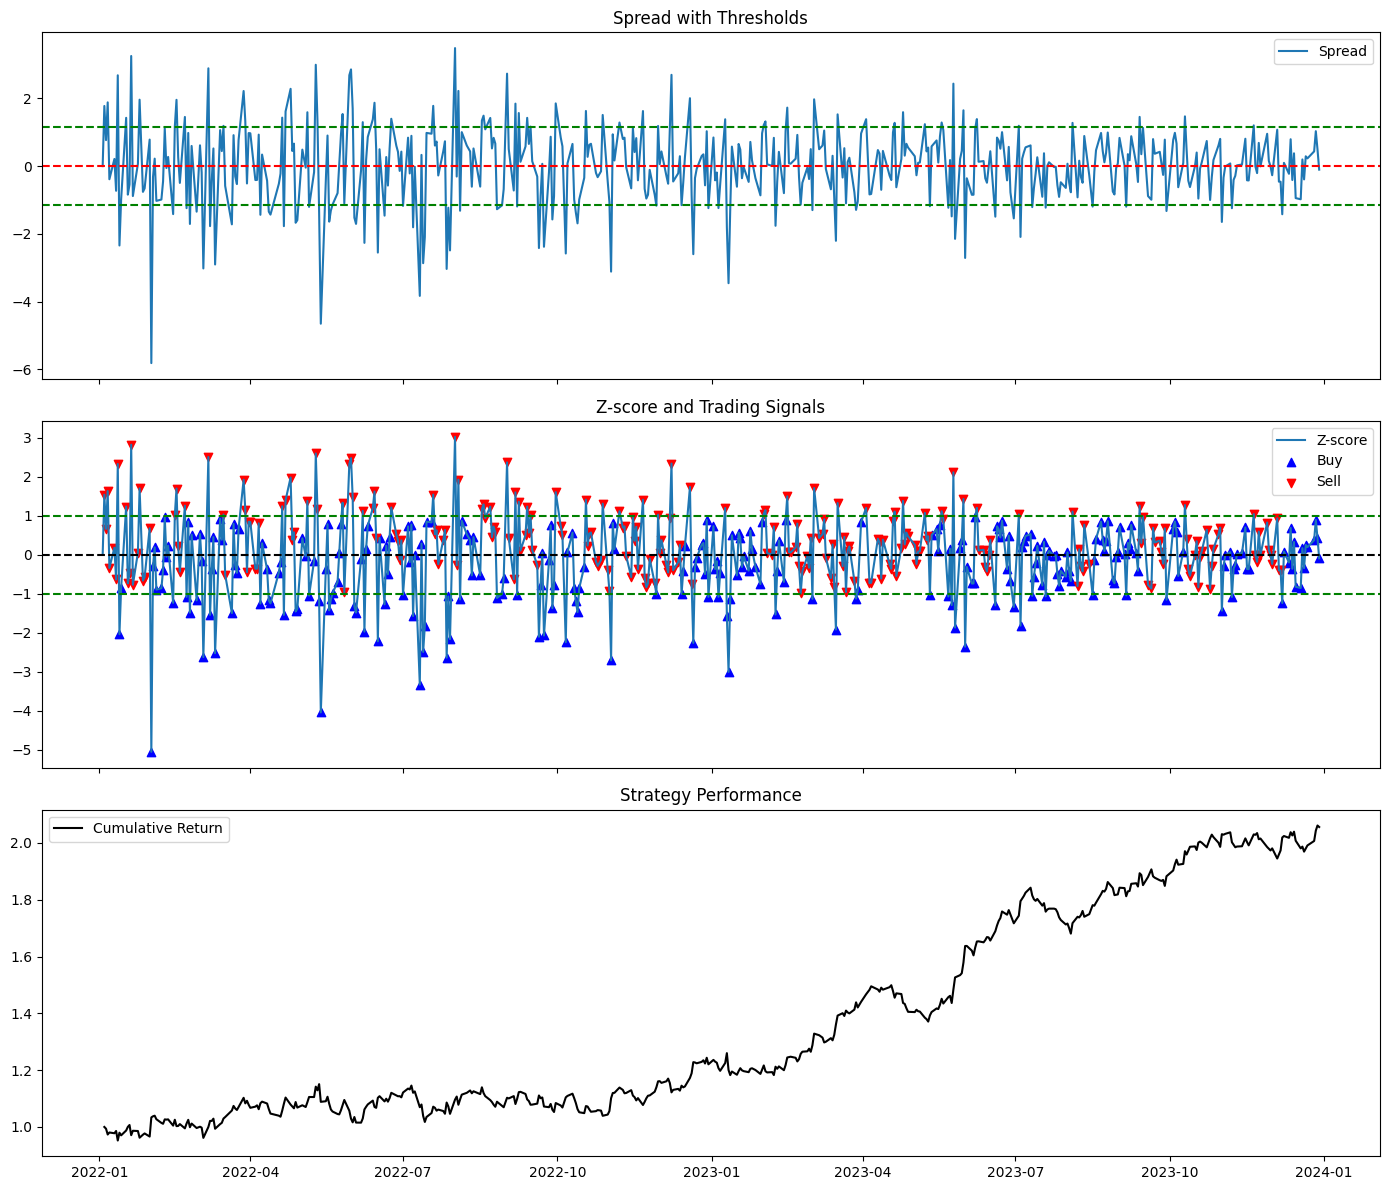

In [13]:
def plot_results(spread, zscore, signals, cumulative_returns, recent_days=None):
    if recent_days:
        end_date = spread.index.max()
        start_date = end_date - pd.Timedelta(days=recent_days)

        spread = spread.loc[start_date:end_date]
        zscore = zscore.loc[start_date:end_date]
        signals = signals.loc[start_date:end_date]
        cumulative_returns = cumulative_returns.loc[start_date:end_date]

    fig, axes = plt.subplots(3, 1, figsize=(14, 12), sharex=True)

    # Spread with mean and ±std dev
    axes[0].plot(spread, label='Spread')
    axes[0].axhline(spread.mean(), color='r', linestyle='--')
    axes[0].axhline(spread.mean() + spread.std(), color='g', linestyle='--')
    axes[0].axhline(spread.mean() - spread.std(), color='g', linestyle='--')
    axes[0].set_title("Spread with Thresholds")
    axes[0].legend()

    # Z-score and signals
    axes[1].plot(zscore, label='Z-score')
    axes[1].axhline(1.0, color='g', linestyle='--')
    axes[1].axhline(-1.0, color='g', linestyle='--')
    axes[1].axhline(0.0, color='k', linestyle='--')
    axes[1].scatter(zscore.index, zscore.where(signals == 1), color='blue', label='Buy', marker='^')
    axes[1].scatter(zscore.index, zscore.where(signals == -1), color='red', label='Sell', marker='v')
    axes[1].set_title("Z-score and Trading Signals")
    axes[1].legend()

    # Cumulative returns
    axes[2].plot(cumulative_returns, color='black', label='Cumulative Return')
    axes[2].set_title("Strategy Performance")
    axes[2].legend()

    plt.tight_layout()
    plt.savefig("Plot.png", dpi=300)  # Save the plot as a PNG file
    plt.show()
plot_results(spread, zscore, signals, cumulative_returns)


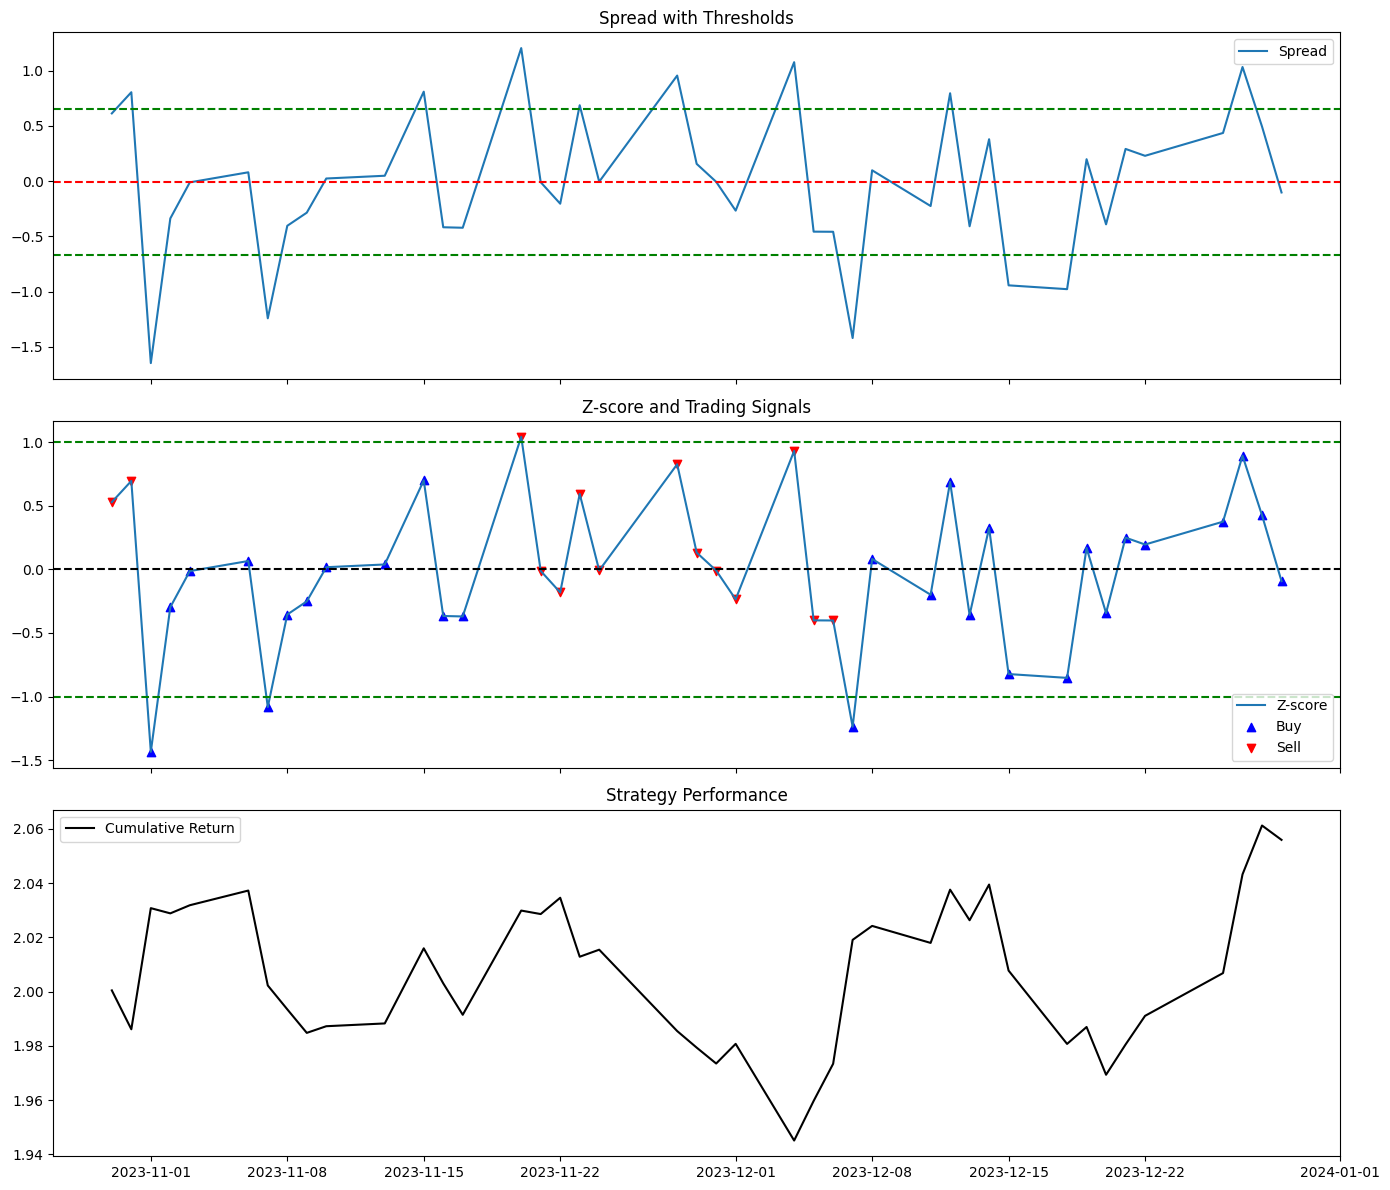

In [12]:
plot_results(spread, zscore, signals, cumulative_returns, recent_days=60)